# Introduction

This notebook demonstrates the use of a trained caffe classification model in python and manual editing of model parameters (net surgery). It is based on the caffe net surgery and filter visualization examples: 

http://nbviewer.ipython.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb

http://nbviewer.ipython.org/github/BVLC/caffe/blob/master/examples/net_surgery.ipynb


First, we need to import pycaffe and other required libraries:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import sys

caffe_root = '/home/user/deep-learning/caffe/'
sys.path.insert(0, caffe_root + 'python')

import caffe

caffe.set_mode_cpu()

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

nfbia15_deep_learning = '/home/user/deep-learning/nfbia15-deep-learning/'


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


# Loading a trained model

In order to load the model, we need a model definition given in a prototxt file and a caffe model file which contains all the model parameters (wights and biases).

In [2]:
net = caffe.Net(nfbia15_deep_learning + 'examples/drive/deployment.prototxt', 
                nfbia15_deep_learning + 'examples/drive/models/drive_iter_200000.caffemodel', 
                caffe.TEST)

# Visualizing model parameters

We'll use the following function to visualize the learned filters:

In [3]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
        
    plt.imshow(data)
    plt.axis('off')


Now, let's  visualize the filters in the first convolutional layer.

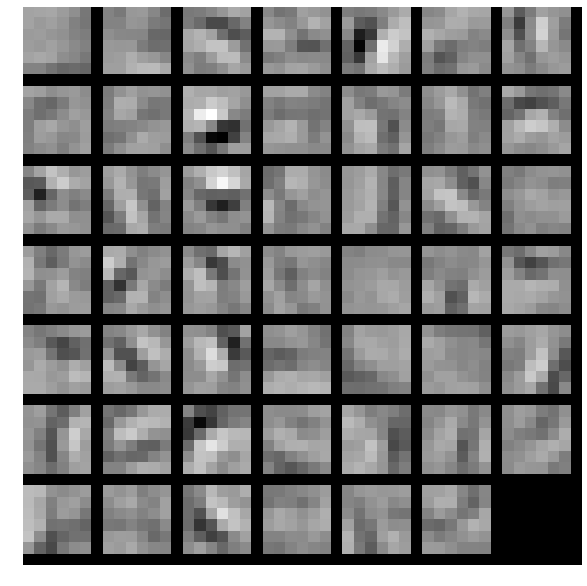

In [4]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(np.squeeze(filters))

Note that compared to /examples/drive/images/conv1.png, the filters here are scaled w.r.t. the extrema across all filters, not within filters. This explains the difference in appearance.

Visualize the filters from the second layer:

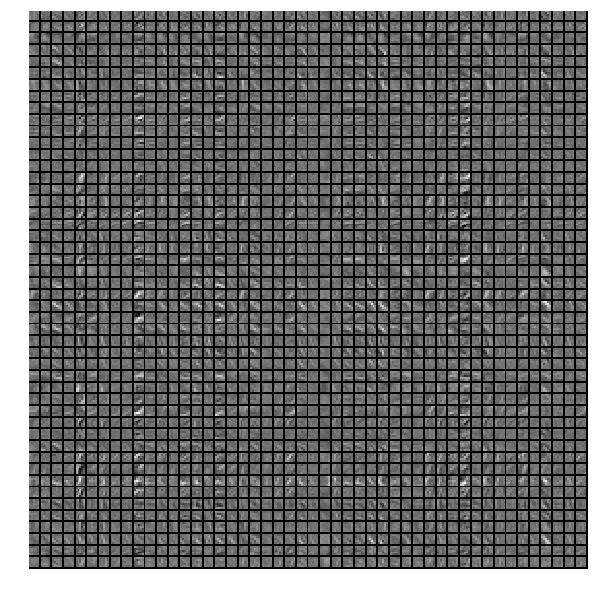

In [5]:
# the parameters are a list of [weights, biases]
filters = net.params['conv2'][0].data
filters.shape
vis_square(filters[:48].reshape(48**2, 5, 5))


In a similar way we can visualize the weights from all the layers in the network.

## Excercise

Load a model with a shorter training time (for example, only 10000 iterations) and visualize the features for the first two layers.

# Creating a fully convolutional model with "network surgery"

The retinal vesell segmentation model is trained to work with input patches of size 65x65 pixels. This is not very efficient if we want to apply it to larger images at every pixel location since a lot of the computations will be repeated.

The convolutional, nonlinarity and max-pooling layers are actually independend of the input size. The only part of the trained model that is dependend on the input size are the fully connected layers. We can recast the trained model to a fully convolutional one by translating the fully connected (inner product) layers to convolutional.

In this specific example, the "ip1" layer can be replaced by a convolutional layer with kernel size 2x2. This is because the input to this layer is a 48x2x2 feature map.

```
layer {name: "ip1"   type: "InnerProduct" bottom: "pool4" top: "ip1" inner_product_param { num_output: 100 }}

layer {name: "ip1_c" type: "Convolution"  bottom: "pool4" top: "ip1" convolution_param   { num_output: 100 
    kernel_size: 2 stride: 1 }}
``` 

In a similar way the "ip2" layer can be replaced with a convolutional layer with kernel size 1x1.

Let's perfrom a networks surgery and cast the trained model to a fully convolutional model:

In [6]:
layers = ['ip1', 'ip2']

layers_conv = ['ip1_c', 'ip2_c']

# reload the net
net = caffe.Net(nfbia15_deep_learning + 'examples/drive/deployment.prototxt', 
                nfbia15_deep_learning + 'examples/drive/models/drive_iter_200000.caffemodel', 
                caffe.TEST)

# fc_params = {name: (weights, biases)}
fc_params = {l: (net.params[l][0].data, net.params[l][1].data) for l in layers}

# load the convolutional network to transplant the parameters.
net_fully_conv = caffe.Net(nfbia15_deep_learning + 'examples/drive/deployment_c.prototxt',
                           nfbia15_deep_learning + 'examples/drive/models/drive_iter_200000.caffemodel',
                           caffe.TEST)

# conv_params = {name: (weights, biases)}
conv_params = {l: (net_fully_conv.params[l][0].data, net_fully_conv.params[l][1].data) for l in layers_conv}

# since the caffe model file does not contain layers named ip1_c and ip2_c, these layer will remain uninitialized

# transplant the parameters
for l, l_conv in zip(layers, layers_conv):
  conv_params[l_conv][0].flat = fc_params[l][0].flat  # flat unrolls the arrays
  conv_params[l_conv][1][...] = fc_params[l][1]
    
# save the model  
net_fully_conv.save(nfbia15_deep_learning + 'examples/drive/models/drive_iter_200000_fully_convolutional.caffemodel')


# Applying the fully convolutional model to a large image

(-0.5, 564.5, 583.5, -0.5)

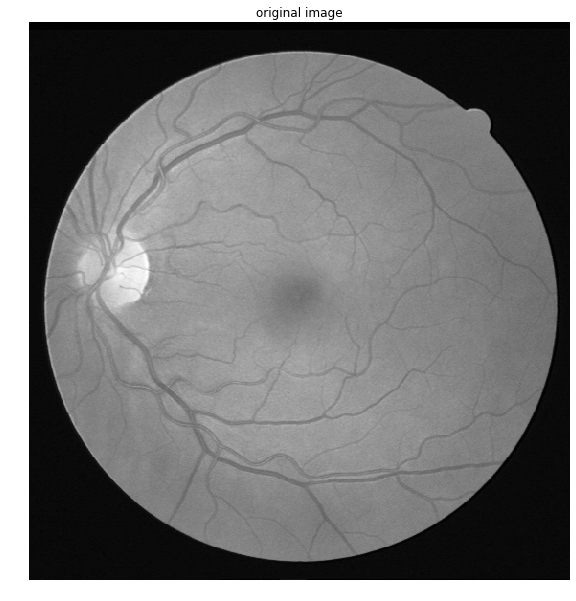

In [7]:
# load the test image
im = caffe.io.load_image(nfbia15_deep_learning + 'examples/drive/images/test.tif', 0)

im = np.squeeze(im);

# display the image
plt.title('original image')
plt.imshow(im)
plt.axis('off')



(-0.5, 32.5, 33.5, -0.5)

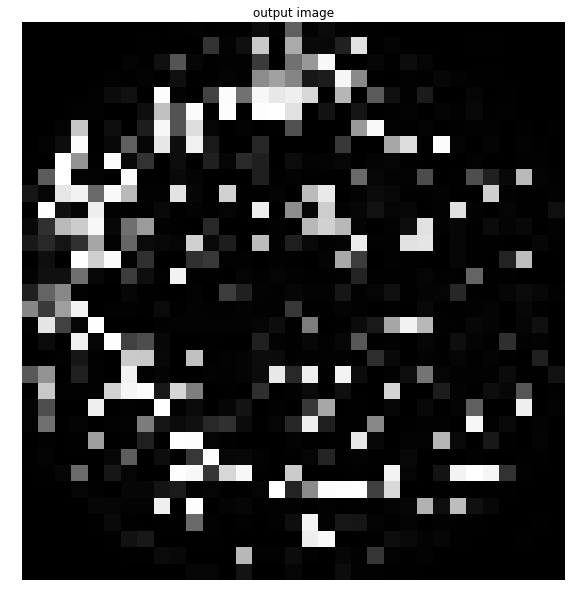

In [8]:
# change the data layer of the network to accept images of size as our test image
net_fully_conv.blobs['data'].reshape(1, 1, im.shape[0], im.shape[1])

# this will affect all subsequent layers so we have to update the entire network
net_fully_conv.reshape()

# preprocess the image in the same manner as during training:
# - substract the mean pixel value of 111
# - caffe.io.load_image() scales the image by 1/255, but we want scaling by 0.015
im = (im*255 - 111)*0.015;

# do a 'forward' trough the entire network
out = net_fully_conv.forward_all(data=np.asarray([im]))

plt.title('output image')
plt.imshow(out['prob'][0,1])
plt.axis('off')


You can immediately notice that an output is not produces for every pixel value. This is due to the downsampling that is performed in the network. The network acts like a filter of size 65x65 (the size of the training patches) with a stride of 16 pixels (because we perform 4 times downsampling by 2).

# Exercise



The following command will return the outputs for the first 8 filters from the first convolutional layer (after the nonlinearity).

```
feat = net_fully_conv.blobs['conv1'].data[0, :8]
```

Use the vis_square function to visualize the filter outputs. Try out with different layers and networks trained for a shorter time.




# Shift-and-stich

If we want to produce an output for every pixel, we can use a "shift-and-stich" technique, i.e. we shift the input image by one pixel at a time and then stitch the results.

(-0.5, 564.5, 583.5, -0.5)

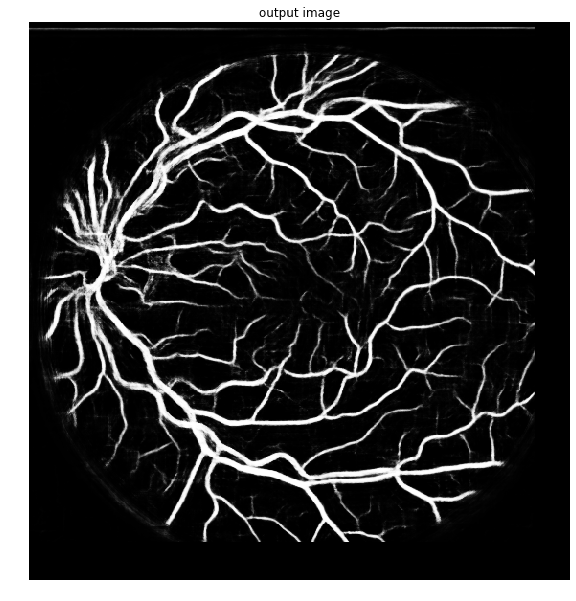

In [9]:
def shift_and_stitch(im, net, filter_size, stride):
      
  s = im.shape;
  im = np.pad(im, (filter_size//2, 0), 'symmetric')
  r = np.zeros(s);
            
  for row in range(0, stride):
    for col in range(0, stride):      
      out = net.forward_all(data=np.asarray([im[row:row+s[0], col:col+s[1]]]))      
      prob = out['prob'][0,1];
      r[row:prob.shape[0]*stride:stride, col:prob.shape[1]*stride:stride] = prob
        
  return r
              
# this can be still quite slow to run on the CPU
# caffe.set_mode_gpu()

r = shift_and_stitch(im, net_fully_conv, 65, 16)

plt.title('output image')
plt.imshow(r)
plt.axis('off')
